In [2]:
import sys
import numpy as np
from pathlib import Path
from collections import defaultdict

sys.path.insert(0, "../python/")

from report_blocks import extract_blocks, BlockInfo


report_path = Path("/home/andre/Documentos/tcc/experiments/reported_blocks_600/")
all_blocks = []

pathlist = Path(report_path).glob('Bikes*.json')
for path in pathlist:
    blocks = extract_blocks(path)
    all_blocks.extend(blocks)


by_lambda = defaultdict(list)
for block in all_blocks:
    by_lambda[block.lf_lambda].append(block)

light_fields = dict()
for lf_lambda, blocks in by_lambda.items():
    lf = dict(
        mse=np.average([b.mse for b in blocks]),
        bpp=np.average([b.bpp for b in blocks]),
        lf_lambda=lf_lambda
    )
    light_fields[lf_lambda] = lf

In [3]:
import matplotlib.pyplot as plt
from ipywidgets import interact

lambdas = sorted(light_fields.keys())

def show_hyperbolic_enhancing(current_lambda=lambdas[len(lambdas) // 2]):
    current_lf = light_fields[current_lambda]

    # rate distortion
    all_bpp = [lf["bpp"] for lf in light_fields.values()]
    all_mse = [lf["mse"] for lf in light_fields.values()]
    all_lambdas = [lf["lf_lambda"] for lf in light_fields.values()]

    plt.scatter(all_bpp, all_mse, color="grey")
    plt.scatter(current_lf["bpp"], current_lf["mse"], color="red")
    plt.axline([current_lf["bpp"], current_lf["mse"]], 
               slope=-current_lambda, label="current light field",
               color="red", linestyle="dashed")
    
    plt.legend()
    plt.xlabel("bpp")
    plt.ylabel("mse")
    plt.show()


    # derivative
    b = -current_lf["lf_lambda"] * current_lf["bpp"] / current_lf["mse"] - 1
    a = current_lf["lf_lambda"] / (current_lf["bpp"] ** b)

    x = np.linspace(min(all_bpp), max(all_bpp))
    y = a * x ** b

    plt.scatter(all_bpp, all_lambdas, color="0.4", label="all light fields")
    plt.plot(x, y, color="red", label="prediction")
    plt.scatter(current_lf["bpp"], current_lf["lf_lambda"], color="red", label="current light field")
    
    plt.legend()
    plt.yscale("log")    
    plt.xlabel("bpp")
    plt.ylabel("lambda")
    plt.show()

interact(show_hyperbolic_enhancing, 
         current_lambda=lambdas,
)

interactive(children=(Dropdown(description='current_lambda', index=75, options=(200, 217, 236, 256, 279, 303, …

<function __main__.show_hyperbolic_enhancing(current_lambda=104259)>

In [4]:
import matplotlib.pyplot as plt
from ipywidgets import interact

lambdas = sorted(light_fields.keys())

def show_hyperbolic_bracketing(start_lambda=lambdas[0], end_lambda=lambdas[-1]):
    all_bpp = [lf["bpp"] for lf in light_fields.values()]
    all_mse = [lf["lf_lambda"] for lf in light_fields.values()]
    plt.scatter(all_bpp, all_mse, color="0.4", label="all light fields")

    start_lf = light_fields[start_lambda]
    end_lf = light_fields[end_lambda]
    
    b = np.log(start_lf["lf_lambda"] / end_lf["lf_lambda"]) / np.log(start_lf["bpp"] / end_lf["bpp"])
    a = end_lf["lf_lambda"] / end_lf["bpp"] ** b

    print(a, b)

    x = np.linspace(start_lf["bpp"], end_lf["bpp"])
    y = a * x ** b

    plt.plot(x, y, color="red", label="prediction")
    plt.scatter(start_lf["bpp"], start_lf["lf_lambda"], color="black", label="start light field")
    plt.scatter(end_lf["bpp"], end_lf["lf_lambda"], color="red", label="end light field")
    
    plt.legend()
    plt.yscale("log")    
    plt.xlabel("bpp")
    plt.ylabel("lambda")
    plt.show()

interact(show_hyperbolic_bracketing, 
         start_lambda=lambdas,
         end_lambda=lambdas,
)

interactive(children=(Dropdown(description='start_lambda', options=(200, 217, 236, 256, 279, 303, 329, 358, 38…

<function __main__.show_hyperbolic_bracketing(start_lambda=200, end_lambda=50000000)>

/usr/lib64/python3.11/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_603279/294886750.py:5: RuntimeWarning: overflow encountered in power
  return a * (x ** b)


[ 7.90811390e-07 -3.91420426e+00]
[[4.44557252e-14 7.02293162e-09]
 [7.02293162e-09 1.10969735e-03]]


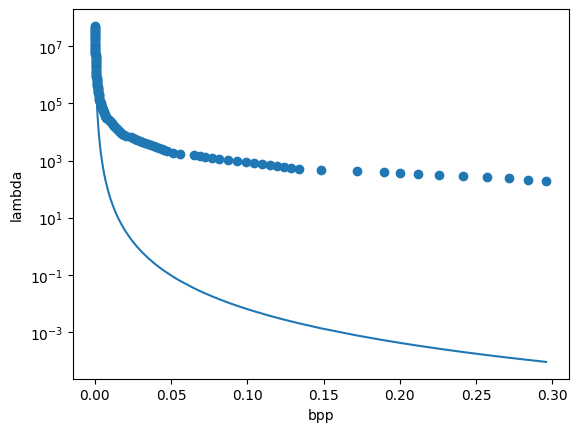

In [5]:
from scipy.optimize import curve_fit


def func(x, a, b):
    return a * (x ** b)

all_bpp = [lf["bpp"] for lf in light_fields.values()]
all_lambdas = [lf["lf_lambda"] for lf in light_fields.values()]

popt, pcov = curve_fit(func, all_bpp, all_lambdas)
plt.plot(all_bpp, func(all_bpp, *popt))
plt.scatter(all_bpp, all_lambdas)

print(popt)
print(pcov)

plt.yscale("log")    
plt.xlabel("bpp")
plt.ylabel("lambda")
plt.show()


[-0.01492009  1.570879  ]
[[ 2.70920871e-08 -9.07307889e-10]
 [-9.07307889e-10  1.39630444e-10]]


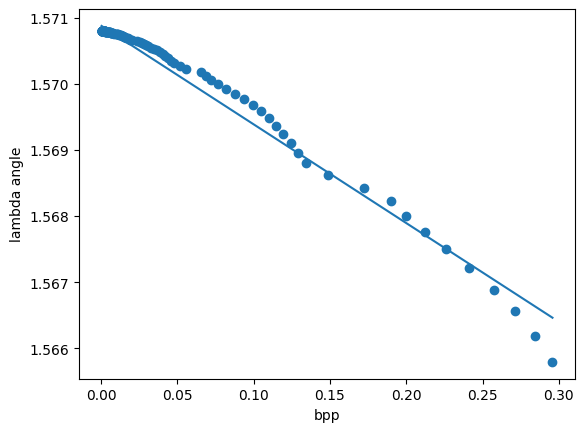

In [6]:
from scipy.optimize import curve_fit


def func(x, a, b):
    return a * x + b

all_bpp = np.array([lf["bpp"] for lf in light_fields.values()])
all_lambdas = np.array([lf["lf_lambda"] for lf in light_fields.values()])
all_angles = np.arctan(all_lambdas)

popt, pcov = curve_fit(func, all_bpp, all_angles)
plt.plot(all_bpp, func(all_bpp, *popt))
plt.scatter(all_bpp, all_angles)

print(popt)
print(pcov)

# plt.yscale("log")    
plt.xlabel("bpp")
plt.ylabel("lambda angle")
plt.show()

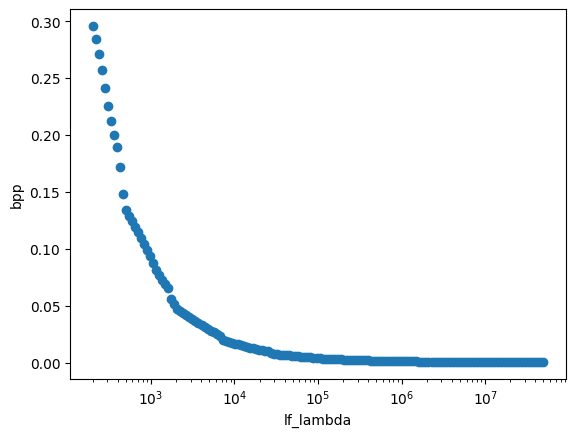

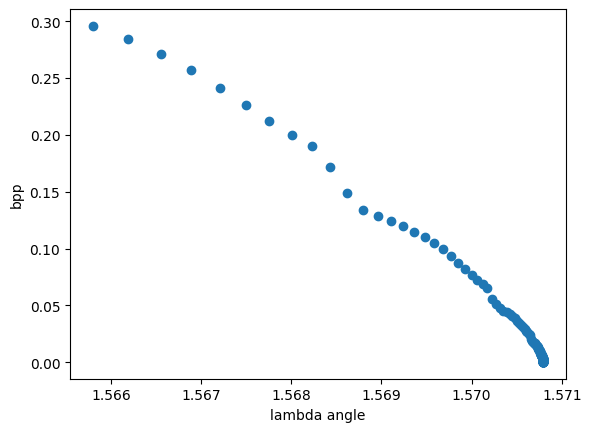

In [7]:
all_bpp = [lf["bpp"] for lf in light_fields.values()]
all_mse = [lf["mse"] for lf in light_fields.values()]
all_lambdas = [lf["lf_lambda"] for lf in light_fields.values()]


plt.scatter(all_lambdas, all_bpp)
plt.xscale("log")    
plt.xlabel("lf_lambda")
plt.ylabel("bpp")
plt.show()

plt.scatter(np.arctan(all_lambdas), all_bpp)
# plt.yscale("log")    
plt.xlabel("lambda angle")
plt.ylabel("bpp")
plt.show()
